# Project Title
**Predicting Peak-Hour Transport Delays in Nairobi Using Machine Learning
Rush Hour Roulette: Matatu Madness**

# Phase 1: Business Understanding
Objective
Build a supervised machine learning classification model to predict when and where overcrowding will occur at bus and matatu stops in Nairobi during peak hours and rainy seasons. This enables transport operators (SACCOs) to proactively deploy additional vehicles and reduce passenger queues before they form.

# Key Questions

When are bus stops most likely to experience overcrowding? (Peak hours? Rainy days?)

Which routes are most vulnerable to congestion-driven delays?

What combination of factors (weather, time of day, route characteristics) best predicts overcrowding?

Can we flag high-risk periods before queues form, rather than reacting after the fact?

# Business Impact
For Transport Operators (SACCOs):

Revenue Optimization: Deploy buses where/when demand is highest → capture more fares

Fleet Efficiency: Reduce idle vehicles during off-peak times; maximize utilization during peaks

Competitive Advantage: Operators with shorter wait times attract more customers

# For Commuters:

Reduced Wait Times: Fewer people left stranded during rush hour

Improved Reliability: More predictable commute times

Better Experience: Less frustration, safer boarding conditions

# For Urban Planning:

Data-Driven Decisions: Inform infrastructure investments (new routes, bus lanes)

Traffic Management: Coordinate with traffic authorities during predicted congestion spikes

Sustainability: Efficient public transport reduces private vehicle use

# Crisis Management:

Detect weather-triggered congestion early (e.g., heavy rain forecasts)

Prepare contingency plans for major events (strikes, road closures)

# Phase 2: Data Understanding

# Dataset Overview

# Importing Required Libraries

In [59]:
# Core
import pandas as pd
import numpy as np
import math


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# Import XGBoost

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance, plot_tree
from datetime import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, accuracy_score, precision_score, recall_score)
import warnings
warnings.filterwarnings('ignore')

# Louding The Datasets

In [3]:
gtfs_df = pd.read_csv("gtfs_clean_hourly_stop_level.csv")
congestion_df = pd.read_csv("matatu_Congestion_clean.csv")
travel_time_df = pd.read_csv("Matatu_travel_time_hourly.csv")
weather_df = pd.read_csv("weather_clean_hourly.csv")


In [4]:
#print(gtfs_df.head())
#print(congestion_df.head())
#print(travel_time_df.head())
#print(weather_df.head())


# Phase 3: Data Cleaning – GTFS Hourly Stop-Level Data
**Objective**

The goal of this phase is to prepare the GTFS hourly stop-level dataset for analysis and machine learning modeling. This involves validating the structure of the data, ensuring correct data types, handling any inconsistencies, and engineering features that are relevant to predicting peak-hour overcrowding at bus and matatu stops in Nairobi.

This dataset represents transport supply patterns (vehicle frequency per stop per hour), which is a critical input for predicting congestion-driven overcrowding.

**Step 1: Load and Inspect the Dataset**

We begin by loading the dataset and inspecting its structure to understand the available features, data types, and completeness.

In [5]:
import pandas as pd

# Load GTFS hourly stop-level data
df_gtfs = pd.read_csv("gtfs_clean_hourly_stop_level.csv")

# Preview the dataset
df_gtfs.head()

# Inspect structure and data types
df_gtfs.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4422 entries, 0 to 4421
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   stop_id         4422 non-null   object 
 1   hour            4422 non-null   int64  
 2   is_weekday      4422 non-null   bool   
 3   trips_per_hour  4422 non-null   int64  
 4   peak_hour       4422 non-null   int64  
 5   stop_name       4422 non-null   object 
 6   stop_lat        4422 non-null   float64
 7   stop_lon        4422 non-null   float64
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 246.3+ KB


**Observations**

   The dataset contains 4,422 rows and 8 columns

   There are no missing values

   Data is already aggregated at hourly stop level

   Key time and supply-related features are present

This confirms the dataset is already well-prepared and requires minimal cleaning.

### Step 2: Understand the Role of Each Column

Before making any changes to the dataset, each column is reviewed and validated against the project’s **business objective**:  
**predicting peak-hour overcrowding at bus and matatu stops**.

This step ensures that all retained features either directly support modeling or provide useful contextual information.

---

### Column Validation Summary

| Column Name        | Purpose                                     | Decision  |
|--------------------|---------------------------------------------|-----------|
| `stop_id`          | Unique identifier for each stop             | Keep      |
| `hour`             | Hour of the day (0–23)                       | Keep      |
| `is_weekday`       | Indicates weekday vs weekend                | Keep      |
| `trips_per_hour`   | Vehicle frequency (supply proxy)             | Keep      |
| `peak_hour`        | Predefined peak-hour indicator               | Keep      |
| `stop_name`        | Human-readable stop name                    | Optional  |
| `stop_lat`         | Latitude of the stop                        | Optional  |
| `stop_lon`         | Longitude of the stop                       | Optional  |

---

### Key Observations

- ✔ All columns contribute **directly or indirectly** to overcrowding prediction  
- ✔ Core modeling features are preserved  
- ✔ Optional columns are useful for **spatial analysis, visualization, and interpretation**  
- ✔ No irrelevant or redundant columns were identified at this stage  

This validation confirms that the dataset structure is **aligned with the project’s analytical and modeling goals**.


**Step 3: Data Type Standardization**

**3.1 Convert Boolean Columns for ML Compatibility**

Machine learning models work best with numeric values. We convert boolean indicators into integers.

In [6]:
# Convert boolean to integer (0 = weekend, 1 = weekday)
df_gtfs['is_weekday'] = df_gtfs['is_weekday'].astype(int)


**Step 4: Data Validation and Sanity Checks**

**4.1 Validate Hour Range**

Ensure that all hour values fall within the valid 24-hour range.

In [7]:
# Keep only valid hour values
df_gtfs = df_gtfs[df_gtfs['hour'].between(0, 23)]


This prevents invalid time entries from introducing noise into the model.

**Step 5: Feature Engineering (Business-Driven)**

Feature engineering is guided directly by the project’s core question:

When and where is overcrowding most likely to occur?

**5.1 Low Supply During Peak Hours (Supply Pressure Indicator)**

Overcrowding is more likely when vehicle supply is low during peak hours.
We create a binary feature that captures this risk.

In [8]:
# Identify low-supply conditions during peak hours
df_gtfs['low_supply_peak'] = (
    (df_gtfs['peak_hour'] == 1) &
    (df_gtfs['trips_per_hour'] < df_gtfs['trips_per_hour'].median())
).astype(int)


**Why this matters:**

Captures operational stress conditions

Strong predictor of long queues and passenger buildup

Easily explainable to transport operators (SACCOs)

**5.2 Distance from CBD (Spatial Risk Factor)**

Congestion patterns in Nairobi are strongly influenced by distance from the CBD.
Stops closer to the CBD tend to experience higher demand and traffic pressure.

We compute an approximate Euclidean distance from the Nairobi CBD.

In [9]:
# Approximate Nairobi CBD coordinates
CBD_LAT, CBD_LON = -1.286389, 36.817223

# Compute distance from CBD
df_gtfs['distance_from_cbd'] = (
    (df_gtfs['stop_lat'] - CBD_LAT)**2 +
    (df_gtfs['stop_lon'] - CBD_LON)**2
) ** 0.5


In [10]:
# Approximate Nairobi CBD coordinates
CBD_LAT, CBD_LON = -1.286389, 36.817223

# Compute distance from CBD
df_gtfs['distance_from_cbd'] = (
    (df_gtfs['stop_lat'] - CBD_LAT)**2 +
    (df_gtfs['stop_lon'] - CBD_LON)**2
) ** 0.5


**Why this matters:**

Supports route vulnerability analysis

Aligns with urban transport planning logic

Enhances spatial interpretability of predictions

**Step 6: Final Output of GTFS Cleaning Phase**

After cleaning and feature engineering, the GTFS dataset now provides:

 Hourly temporal features
 
 Vehicle supply indicators
 
 Peak-hour logic
 
 Spatial congestion signal
 
 Machine-learning-ready numeric features

This dataset will act as the base table for merging travel time, congestion, and weather data in subsequent steps.

# Matatu Travel Time (Hourly)

**Objective**

The purpose of this step is to clean and prepare the hourly matatu travel time dataset for use in predicting peak-hour transport delays and overcrowding. Travel time statistics act as a proxy for traffic congestion and delay severity, which directly affect how frequently vehicles arrive at stops and therefore influence passenger buildup.

This dataset provides hour-level congestion signals that will later be merged with GTFS supply and weather data.

**Step 1: Load and Inspect the Dataset**

We start by loading the dataset and examining its structure to understand the available features and confirm data completeness.

In [11]:
import pandas as pd

# Load matatu travel time data
df_travel = pd.read_csv("Matatu_travel_time_hourly.csv")

# Preview the dataset
df_travel.head()

# Inspect structure and data types
df_travel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hour                99 non-null     float64
 1   avg_travel_time     99 non-null     float64
 2   median_travel_time  99 non-null     float64
 3   p90_travel_time     99 non-null     float64
 4   high_congestion     99 non-null     float64
dtypes: float64(5)
memory usage: 4.0 KB


**Observations**


The dataset contains 99 rows and 5 columns

All columns are numeric (float64)

No missing values are present

Data is aggregated at hourly level

This indicates the dataset is already clean but still requires validation and feature preparation.

### Step 2: Understand Column Roles (Business Alignment)

Before proceeding with data cleaning, each column is evaluated against the **business objective** of modeling and predicting **travel delays and congestion patterns**.

---

### Column Evaluation Summary

| Column Name           | Description                          | Decision |
|-----------------------|--------------------------------------|----------|
| `hour`                | Hour of the day (0–23)                | Keep     |
| `avg_travel_time`     | Mean travel time per hour             | Keep     |
| `median_travel_time`  | Typical travel duration               | Keep     |
| `p90_travel_time`     | Indicator of severe delays            | Keep     |
| `high_congestion`     | Predefined congestion classification | Keep     |

---

### Key Observations

-  All columns are directly relevant to **delay and congestion modeling**
-  Each feature captures a different aspect of **traffic behavior**
-  No unnecessary or redundant columns were identified for removal

This confirms that the dataset is **well-aligned with the modeling objectives** and ready for subsequent cleaning and feature preparation steps.


**Step 3: Data Validation and Type Correction**
3.1 Convert Hour to Integer

Although hour is numeric, it should be an integer for time-based joins and analysis.

In [12]:
df_travel['hour'] = df_travel['hour'].astype(int)


**3.2 Validate Hour Range**

Ensure all hour values fall within a valid 24-hour range

In [13]:
df_travel = df_travel[df_travel['hour'].between(0, 23)]


This prevents invalid time values from affecting model performance.

**Step 4: Feature Engineering (Delay Severity Signals)**
    
**4.1 High Delay Indicator Using 90th Percentile**

The 90th percentile travel time captures extreme congestion conditions, which are especially relevant for overcrowding.

In [14]:
df_travel['severe_delay'] = (
    df_travel['p90_travel_time'] >
    df_travel['p90_travel_time'].quantile(0.75)
).astype(int)


**Why this matters:**

Captures worst-case travel delays

Strong signal for reduced vehicle arrival frequency

Aligns with peak-hour congestion dynamics

**4.2 Normalize Average Travel Time (Optional for ML)**

Standardizing travel time allows the model to compare relative delays across hours.

In [15]:
df_travel['avg_travel_time_zscore'] = (
    (df_travel['avg_travel_time'] - df_travel['avg_travel_time'].mean())
    / df_travel['avg_travel_time'].std()
)


**4.3 Ensure Binary Congestion Flag**

The high_congestion column should be binary (0/1).

In [16]:
df_travel['high_congestion'] = df_travel['high_congestion'].astype(int)


**Step 5: Final Output of Travel Time Cleaning Phase**

After cleaning and feature engineering, the travel time dataset provides:

✔ Hour-level congestion indicators
✔ Severe delay signals (p90-based)
✔ ML-ready numeric features
✔ Clean time keys for merging

This dataset is now ready to be merged with GTFS supply and weather datasets.

In [17]:
df_travel.head(5)

,hour,avg_travel_time,median_travel_time,p90_travel_time,high_congestion,severe_delay,avg_travel_time_zscore
0,1,3992.26,3937.5,5648.6,0,0,-0.834775
1,2,4094.07,4144.0,5709.1,0,0,-0.784356
2,3,4048.97,4149.5,5607.4,0,0,-0.806691
3,4,4322.50,4398.0,5959.4,0,0,-0.671231
4,5,4391.85,4419.0,6174.6,0,0,-0.636887


#  Matatu Congestion Dataset

**Objective**

This phase focuses on cleaning and preparing the matatu congestion dataset, which contains route-level congestion indicators. Congestion directly affects vehicle frequency and travel time, influencing passenger overcrowding during peak hours. This dataset will later be merged with GTFS supply and travel time data for predictive modeling.

**Step 1: Load and Inspect the Dataset**

We start by loading the dataset and inspecting its structure to understand the features, data types, and completeness.

In [18]:
import pandas as pd

# Load matatu congestion data
df_cong = pd.read_csv("matatu_Congestion_clean.csv")

# Preview the first rows
df_cong.head()

# Inspect structure and data types
df_cong.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591 entries, 0 to 1590
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   file                1591 non-null   object 
 1   avg_travel_time     1591 non-null   float64
 2   median_travel_time  1591 non-null   float64
 3   p90_travel_time     1591 non-null   float64
 4   hour                1590 non-null   float64
 5   high_congestion     1591 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 74.7+ KB


**Observations**

1,591 rows and 6 columns

Columns include travel time metrics and a congestion flag

hour has one missing value, which must be handled

The file column represents the source or route identifier

### Step 2: Understand Column Roles (Business Alignment)

Each column is reviewed to ensure alignment with the **project objective** of analyzing and predicting **travel delays and congestion patterns**.

---

### Column Evaluation Summary

| Column Name        | Description                     | Decision                                  |
|-------------------|---------------------------------|-------------------------------------------|
| `file`             | Route identifier (or source file) | Keep (rename for clarity and merge compatibility) |
| `avg_travel_time`  | Average travel time per hour     | Keep                                      |
| `median_travel_time` | Typical travel duration        | Keep                                      |
| `p90_travel_time`  | Extreme travel time             | Keep                                      |
| `hour`             | Hour of day (0–23)              | Keep                                      |
| `high_congestion`  | Binary congestion flag           | Keep                                      |

---

### Key Observations

- ✔ All columns are relevant to **delay and congestion analysis**
- ✔ Only `file` may require **renaming** to improve clarity and ensure **compatibility when merging datasets**


**Step 3: Clean Column Names**

Normalize column names for consistency across datasets.

In [19]:
# Standardize column names
df_cong.columns = (
    df_cong.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

# Rename 'file' to 'route_id' for clarity
df_cong.rename(columns={'file': 'route_id'}, inplace=True)


**Step 4: Handle Missing Values**
    
**4.1 Inspect missing values**

In [20]:
df_cong.isnull().sum()


route_id              0
avg_travel_time       0
median_travel_time    0
p90_travel_time       0
hour                  1
high_congestion       0
dtype: int64

Only hour has 1 missing value. Since it is critical for merging by time, we drop this row.

In [21]:
df_cong = df_cong.dropna(subset=['hour'])


**4.2 Validate Hour Column**

Ensure all hours are within 0–23 range.

In [22]:
df_cong['hour'] = df_cong['hour'].astype(int)
df_cong = df_cong[df_cong['hour'].between(0, 23)]


**Step 5: Feature Engineering (Congestion Indicators)**
    
**5.1 Severe Congestion Signal (Optional)**

Use the 90th percentile travel time as an additional extreme congestion indicator.

In [23]:
df_cong['severe_congestion'] = (
    df_cong['p90_travel_time'] > df_cong['p90_travel_time'].quantile(0.75)
).astype(int)


**Business Interpretation:**

Flags hours where congestion is unusually high

Aligns with overcrowding risk, particularly during peak hours

**5.2 Normalize Travel Times (Optional for ML)**

Standardize travel time metrics for model stability.

In [24]:
df_cong['avg_travel_time_zscore'] = (
    (df_cong['avg_travel_time'] - df_cong['avg_travel_time'].mean())
    / df_cong['avg_travel_time'].std()
)

df_cong['median_travel_time_zscore'] = (
    (df_cong['median_travel_time'] - df_cong['median_travel_time'].mean())
    / df_cong['median_travel_time'].std()
)


**Step 6: Final Output of Congestion Cleaning Phase**

After cleaning and feature engineering, the congestion dataset provides:

 Hourly route-level congestion indicator
 
 Binary high and severe congestion signals
 
 ML-ready numeric travel time features
 
 Clean time keys (hour) and route keys (route_id) for merging

This dataset is now ready to be merged with GTFS supply and travel time datasets, forming a comprehensive hourly stop-route table for predictive modeling.

# Weather Dataset (Hourly)

**Objective**

The purpose of this step is to clean and prepare hourly weather data for the overcrowding prediction model. Weather conditions, particularly rainfall, are a key factor influencing travel delays, vehicle frequency, and passenger behavior. This dataset will later be merged with GTFS supply, travel time, and congestion datasets to provide a complete feature set.

**Step 1: Load and Inspect the Dataset**

In [25]:
import pandas as pd

# Load weather data
df_weather = pd.read_csv("weather_clean_hourly.csv")

# Preview dataset
df_weather.head()

# Inspect structure and data types
df_weather.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour         48 non-null     int64  
 1   is_weekday   48 non-null     bool   
 2   rain_mm      48 non-null     float64
 3   is_rain      48 non-null     float64
 4   heavy_rain   48 non-null     float64
 5   temperature  48 non-null     float64
dtypes: bool(1), float64(4), int64(1)
memory usage: 2.0 KB


**Observations**

48 rows and 6 columns

Columns include hour, weekday indicator, rainfall, heavy rain, and temperature

No missing values are present

is_weekday is boolean; is_rain and heavy_rain are numeric (0/1 or mm values)

**Step 2: Normalize Column Names**

Standardize column names for consistency and merging with other datasets.

In [26]:
df_weather.columns = (
    df_weather.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)


**Step 3: Data Type Standardization**

3.1 Convert Boolean to Integer

In [27]:
df_weather['is_weekday'] = df_weather['is_weekday'].astype(int)


**3.2 Ensure Rain Indicators are Binary**

In [28]:
df_weather['is_rain'] = df_weather['is_rain'].apply(lambda x: 1 if x > 0 else 0)
df_weather['heavy_rain'] = df_weather['heavy_rain'].apply(lambda x: 1 if x > 0 else 0)


**Why this matters:**

ML models require numeric inputs

Clearly distinguishes between rain/no-rain and heavy-rain/no-heavy-rain conditions

**Step 4: Validate Hour Column**

Ensure all hour values are in the 0–23 range.

In [29]:
df_weather = df_weather[df_weather['hour'].between(0, 23)]


**Step 5: Feature Engineering (Weather Impact Signals)**
    
**5.1 Rain Pressure Feature**

Identify hours when rain is likely to affect traffic delays.

In [30]:
# Define moderate rain indicator
df_weather['moderate_rain'] = ((df_weather['is_rain'] == 1) & (df_weather['heavy_rain'] == 0)).astype(int)


**Interpretation:**

Moderate rain may increase delays slightly

Heavy rain increases travel delays and overcrowding risk

**5.2 Temperature Standardization (Optional for ML)**

In [31]:
df_weather['temperature_zscore'] = (
    (df_weather['temperature'] - df_weather['temperature'].mean()) 
    / df_weather['temperature'].std()
)


**Why:**

Allows the model to detect unusually hot or cold conditions that might affect passenger demand or travel speed

**Step 6: Final Output of Weather Cleaning Phase**

After cleaning and feature engineering, the weather dataset provides:

 Hourly weather indicators
 
 Binary rain and heavy rain flags
 
 Moderate rain feature
 
 ML-ready numeric temperature feature
 
 Clean time keys (hour) and weekday keys (is_weekday) for merging

This dataset is now ready to be merged with GTFS supply, travel time, and congestion datasets for comprehensive modeling.

In [32]:
df_weather.head()

,hour,is_weekday,rain_mm,is_rain,heavy_rain,temperature,moderate_rain,temperature_zscore
0,0,0,0.075000,1,0,15.725000,1,-1.030410
1,0,1,0.121429,1,0,15.657143,1,-1.049249
2,1,0,0.050000,1,0,15.625000,1,-1.058172
3,1,1,0.114286,1,0,15.457143,1,-1.104772
4,2,0,0.125000,1,0,15.375000,1,-1.127577


**Dataset Merging – Master Modeling Table**

**Objective**

Combine all cleaned datasets into a single master table for supervised machine learning.

This table will contain:

  Supply data (GTFS – trips per hour)

  Travel time / delay indicators (Matatu Travel Time)

  Route congestion metrics (Matatu Congestion)

  Weather features (rain, temperature, heavy rain)

The goal is to create a complete, hourly, stop-level dataset for predicting overcrowding at matatu/bus stops.

**Step 1: Prepare Keys for Merging**


We need common keys across datasets:

Dataset	Key Column(s)
GTFS	stop_id, hour
Travel Time	hour (may need route mapping)
Congestion	route_id, hour
Weather	hour, is_weekday

**Important:**


GTFS is stop-level

Congestion and travel time are route/hour level

Weather is hour-level

**We will merge stepwise:**


GTFS + Travel Time (on hour)

Add Congestion (on hour, optionally route_id)

Add Weather (on hour and is_weekday)

**Step 2: Merge GTFS and Travel Time**

In [33]:
# Merge GTFS and travel time data on 'hour'
df_master = pd.merge(
    df_gtfs,
    df_travel[['hour', 'avg_travel_time', 'median_travel_time', 'p90_travel_time', 'high_congestion', 'severe_delay', 'avg_travel_time_zscore']],
    on='hour',
    how='left'
)

# Preview merged table
df_master.head()


,stop_id,hour,is_weekday,trips_per_hour,peak_hour,stop_name,stop_lat,stop_lon,low_supply_peak,distance_from_cbd,avg_travel_time,median_travel_time,p90_travel_time,high_congestion,severe_delay,avg_travel_time_zscore
0,0001RLW,6,1,11,1,Railways,-1.290884,36.828242,0,0.011901,4279.27,4217.5,6212.2,0,0,-0.692640
1,0001RLW,7,1,3,1,Railways,-1.290884,36.828242,0,0.011901,3847.35,3883.0,5704.7,0,0,-0.906538
2,0100..M,6,1,1,1,K.M.,-1.167727,36.919008,0,0.156336,4279.27,4217.5,6212.2,0,0,-0.692640
3,010044G,6,1,1,1,44 Githurai,-1.195514,36.902695,0,0.124755,4279.27,4217.5,6212.2,0,0,-0.692640
4,0100A.P,6,1,1,1,A.P.,-1.178289,36.911960,0,0.143738,4279.27,4217.5,6212.2,0,0,-0.692640


**What we gain:**

Each stop now has hourly travel time and delay signals

**Step 3: Merge Congestion Data**

In [34]:
# Merge congestion data on 'hour'
df_master = pd.merge(
    df_master,
    df_cong[['hour', 'route_id', 'avg_travel_time', 'median_travel_time', 'p90_travel_time', 'high_congestion', 'severe_congestion', 'avg_travel_time_zscore', 'median_travel_time_zscore']],
    left_on=['hour'],  # can include route mapping if available
    right_on=['hour'],
    how='left',
    suffixes=('_travel', '_cong')
)

# Preview table
df_master.head()


,stop_id,hour,is_weekday,trips_per_hour,peak_hour,stop_name,stop_lat,stop_lon,low_supply_peak,distance_from_cbd,...,severe_delay,avg_travel_time_zscore_travel,route_id,avg_travel_time_cong,median_travel_time_cong,p90_travel_time_cong,high_congestion_cong,severe_congestion,avg_travel_time_zscore_cong,median_travel_time_zscore
0,0001RLW,6,1,11,1,Railways,-1.290884,36.828242,0,0.011901,...,0,-0.692640,matonwalk-6.csv,4279.27,4217.5,6212.2,0,0,-0.691020,-0.505320
1,0001RLW,7,1,3,1,Railways,-1.290884,36.828242,0,0.011901,...,0,-0.906538,matonwalk-7.csv,3847.35,3883.0,5704.7,0,0,-0.779341,-0.572425
2,0100..M,6,1,1,1,K.M.,-1.167727,36.919008,0,0.156336,...,0,-0.692640,matonwalk-6.csv,4279.27,4217.5,6212.2,0,0,-0.691020,-0.505320
3,010044G,6,1,1,1,44 Githurai,-1.195514,36.902695,0,0.124755,...,0,-0.692640,matonwalk-6.csv,4279.27,4217.5,6212.2,0,0,-0.691020,-0.505320
4,0100A.P,6,1,1,1,A.P.,-1.178289,36.911960,0,0.143738,...,0,-0.692640,matonwalk-6.csv,4279.27,4217.5,6212.2,0,0,-0.691020,-0.505320


**Notes:**

Suffixes avoid column conflicts (_travel vs _cong)

Congestion signals add route-level delay and pressure indicators

**Step 4: Merge Weather Data**

In [35]:
# Merge weather data on 'hour' and 'is_weekday'
df_master = pd.merge(
    df_master,
    df_weather[['hour', 'is_weekday', 'rain_mm', 'is_rain', 'heavy_rain', 'moderate_rain', 'temperature_zscore']],
    on=['hour', 'is_weekday'],
    how='left'
)

# Preview final master table
df_master.head()


,stop_id,hour,is_weekday,trips_per_hour,peak_hour,stop_name,stop_lat,stop_lon,low_supply_peak,distance_from_cbd,...,p90_travel_time_cong,high_congestion_cong,severe_congestion,avg_travel_time_zscore_cong,median_travel_time_zscore,rain_mm,is_rain,heavy_rain,moderate_rain,temperature_zscore
0,0001RLW,6,1,11,1,Railways,-1.290884,36.828242,0,0.011901,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989
1,0001RLW,7,1,3,1,Railways,-1.290884,36.828242,0,0.011901,...,5704.7,0,0,-0.779341,-0.572425,0.057143,1,0,1,0.412214
2,0100..M,6,1,1,1,K.M.,-1.167727,36.919008,0,0.156336,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989
3,010044G,6,1,1,1,44 Githurai,-1.195514,36.902695,0,0.124755,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989
4,0100A.P,6,1,1,1,A.P.,-1.178289,36.911960,0,0.143738,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989


**What we gain:**

Hourly weather indicators added for each stop

Ensures that rain and temperature effects are captured in modeling

**Step 5: Validate Master Table**

In [36]:
# Check overall info
df_master.info()

# Check for missing values
df_master.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4422 entries, 0 to 4421
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   stop_id                        4422 non-null   object 
 1   hour                           4422 non-null   int64  
 2   is_weekday                     4422 non-null   int32  
 3   trips_per_hour                 4422 non-null   int64  
 4   peak_hour                      4422 non-null   int64  
 5   stop_name                      4422 non-null   object 
 6   stop_lat                       4422 non-null   float64
 7   stop_lon                       4422 non-null   float64
 8   low_supply_peak                4422 non-null   int32  
 9   distance_from_cbd              4422 non-null   float64
 10  avg_travel_time_travel         4422 non-null   float64
 11  median_travel_time_travel      4422 non-null   float64
 12  p90_travel_time_travel         4422 non-null   f

stop_id                          0
hour                             0
is_weekday                       0
trips_per_hour                   0
peak_hour                        0
stop_name                        0
stop_lat                         0
stop_lon                         0
low_supply_peak                  0
distance_from_cbd                0
avg_travel_time_travel           0
median_travel_time_travel        0
p90_travel_time_travel           0
high_congestion_travel           0
severe_delay                     0
avg_travel_time_zscore_travel    0
route_id                         0
avg_travel_time_cong             0
median_travel_time_cong          0
p90_travel_time_cong             0
high_congestion_cong             0
severe_congestion                0
avg_travel_time_zscore_cong      0
median_travel_time_zscore        0
rain_mm                          0
is_rain                          0
heavy_rain                       0
moderate_rain                    0
temperature_zscore  

**All key features for ML are present**

Hourly stop-level, route-level, and weather features aligned

Missing values are expected only if some stops have no corresponding travel/congestion data for a specific hour (can be filled later if needed)

**Step 6: Final Master Table Ready for Modeling**

Rows: Hourly stop-level observations

Columns:

Supply features (trips_per_hour, low_supply_peak)

Travel time and delay (avg_travel_time, severe_delay)

Congestion metrics (high_congestion, severe_congestion)

Weather (rain_mm, is_rain, heavy_rain, temperature_zscore)

Temporal features (hour, is_weekday)

Spatial features (distance_from_cbd, stop_lat, stop_lon)

In [37]:
df_master


,stop_id,hour,is_weekday,trips_per_hour,peak_hour,stop_name,stop_lat,stop_lon,low_supply_peak,distance_from_cbd,...,p90_travel_time_cong,high_congestion_cong,severe_congestion,avg_travel_time_zscore_cong,median_travel_time_zscore,rain_mm,is_rain,heavy_rain,moderate_rain,temperature_zscore
0,0001RLW,6,1,11,1,Railways,-1.290884,36.828242,0,0.011901,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989
1,0001RLW,7,1,3,1,Railways,-1.290884,36.828242,0,0.011901,...,5704.7,0,0,-0.779341,-0.572425,0.057143,1,0,1,0.412214
2,0100..M,6,1,1,1,K.M.,-1.167727,36.919008,0,0.156336,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989
3,010044G,6,1,1,1,44 Githurai,-1.195514,36.902695,0,0.124755,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989
4,0100A.P,6,1,1,1,A.P.,-1.178289,36.911960,0,0.143738,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,0813KKS,6,1,3,1,Kikuyu Terminus,-1.246669,36.665068,0,0.157254,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989
4418,0813LMT,6,1,3,1,Limuru Town Terminal,-1.108418,36.643175,0,0.248930,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989
4419,0813LMT,7,1,3,1,Limuru Town Terminal,-1.108418,36.643175,0,0.248930,...,5704.7,0,0,-0.779341,-0.572425,0.057143,1,0,1,0.412214
4420,0813WSA,6,1,3,1,Westlands,-1.262398,36.803674,0,0.027553,...,6212.2,0,0,-0.691020,-0.505320,0.085714,1,0,1,-0.146989


**Saving the dataset,the cleaned dataset**

In [38]:
#df_master.to_csv("df_master.csv", index=False)
df_master = pd.read_csv("df_master.csv")
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4422 entries, 0 to 4421
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   stop_id                        4422 non-null   object 
 1   hour                           4422 non-null   int64  
 2   is_weekday                     4422 non-null   int64  
 3   trips_per_hour                 4422 non-null   int64  
 4   peak_hour                      4422 non-null   int64  
 5   stop_name                      4422 non-null   object 
 6   stop_lat                       4422 non-null   float64
 7   stop_lon                       4422 non-null   float64
 8   low_supply_peak                4422 non-null   int64  
 9   distance_from_cbd              4422 non-null   float64
 10  avg_travel_time_travel         4422 non-null   float64
 11  median_travel_time_travel      4422 non-null   float64
 12  p90_travel_time_travel         4422 non-null   f

**Features we Exclude (to avoid leakage or redundancy while doing the modeling)**

stop_id, stop_name (high cardinality, not useful unless encoded as clusters)

high_congestion_travel, severe_delay, severe_congestion (if using low_supply_peak as target)

Duplicate traffic metrics — choose one set (travel vs cong) to avoid multicollinearity.

In [39]:
# Columns to exclude
cols_to_exclude = [
    
    "stop_id", "stop_name",            # high cardinality
    "high_congestion_travel",          # leakage if using low_supply_peak
    "severe_delay", 
    "severe_congestion",
    # Duplicate traffic metrics — choose one set (we'll keep travel set, drop congestion set)
    "avg_travel_time_cong", 
    "median_travel_time_cong", 
    "p90_travel_time_cong", 
    "high_congestion_cong", 
    "avg_travel_time_zscore_cong"
]

# Drop the columns
df_model = df_master.drop(columns=cols_to_exclude)

# Quick check
print(df_model.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4422 entries, 0 to 4421
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hour                           4422 non-null   int64  
 1   is_weekday                     4422 non-null   int64  
 2   trips_per_hour                 4422 non-null   int64  
 3   peak_hour                      4422 non-null   int64  
 4   stop_lat                       4422 non-null   float64
 5   stop_lon                       4422 non-null   float64
 6   low_supply_peak                4422 non-null   int64  
 7   distance_from_cbd              4422 non-null   float64
 8   avg_travel_time_travel         4422 non-null   float64
 9   median_travel_time_travel      4422 non-null   float64
 10  p90_travel_time_travel         4422 non-null   float64
 11  avg_travel_time_zscore_travel  4422 non-null   float64
 12  route_id                       4422 non-null   o

In [91]:
# Columns to remove
#engineered_cols = ["peak_hour_better", "overcrowding_correct"]

# Drop the engineered columns
#df_model = df_model.drop(columns=engineered_cols)

# Check the dataframe
print(df_model.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4422 entries, 0 to 4421
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hour                           4422 non-null   int64  
 1   is_weekday                     4422 non-null   int64  
 2   trips_per_hour                 4422 non-null   int64  
 3   peak_hour                      4422 non-null   int64  
 4   stop_lat                       4422 non-null   float64
 5   stop_lon                       4422 non-null   float64
 6   low_supply_peak                4422 non-null   int64  
 7   distance_from_cbd              4422 non-null   float64
 8   avg_travel_time_travel         4422 non-null   float64
 9   median_travel_time_travel      4422 non-null   float64
 10  p90_travel_time_travel         4422 non-null   float64
 11  avg_travel_time_zscore_travel  4422 non-null   float64
 12  route_id                       4422 non-null   o

In [42]:

# Set style for better visualizations
#plt.style.use('seaborn-v0_8-darkgrid')
#sns.set_palette("husl")

# Display all columns
pd.set_option('display.max_columns', None)

**Prepare Data For Modeling**

In [43]:
# Separate features and target
target = 'low_supply_peak'

# Features (all columns except target)
features = [col for col in df_model.columns if col != target]

X = df_model[features]
y = df_model[target]

print(f"Dataset shape: {df_model.shape}")
print(f"Features: {len(features)}")
print(f"Target variable: {target}")
print(f"Class distribution:")
print(y.value_counts())
#print(f"Class ratio (0:1): {y.value_counts()[0]/y.value_counts()[1]:.2f}:1")

Dataset shape: (4422, 19)
Features: 18
Target variable: low_supply_peak
Class distribution:
0    4422
Name: low_supply_peak, dtype: int64


In [44]:
# Run this to see what's really in our dataset because of that  0  4422
print("Dataset info:")
print(df_model.info())

print("\nFirst few rows:")
print(df_model.head())

print("\nSummary statistics:")
print(df_model.describe())

print("\nChecking for any binary columns:")
binary_cols = []
for col in df_model.columns:
    if df_model[col].nunique() == 2:
        binary_cols.append(col)
        print(f"{col}: {df_model[col].unique()}")

print(f"\nBinary columns found: {binary_cols}")

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4422 entries, 0 to 4421
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hour                           4422 non-null   int64  
 1   is_weekday                     4422 non-null   int64  
 2   trips_per_hour                 4422 non-null   int64  
 3   peak_hour                      4422 non-null   int64  
 4   stop_lat                       4422 non-null   float64
 5   stop_lon                       4422 non-null   float64
 6   low_supply_peak                4422 non-null   int64  
 7   distance_from_cbd              4422 non-null   float64
 8   avg_travel_time_travel         4422 non-null   float64
 9   median_travel_time_travel      4422 non-null   float64
 10  p90_travel_time_travel         4422 non-null   float64
 11  avg_travel_time_zscore_travel  4422 non-null   float64
 12  route_id                       442

In [47]:
# Check how data is filled in the original local dataset df_master
if 'df_master' in locals():
    print("Checking original df_master for target variable variation...")
    print("\nlow_supply_peak in original:")
    print(df_master['low_supply_peak'].value_counts())
    
    print("\npeak_hour in original:")
    print(df_master['peak_hour'].value_counts())
    
    print("\nis_weekday in original:")
    print(df_master['is_weekday'].value_counts())

Checking original df_master for target variable variation...

low_supply_peak in original:
0    4422
Name: low_supply_peak, dtype: int64

peak_hour in original:
1    4422
Name: peak_hour, dtype: int64

is_weekday in original:
1    4422
Name: is_weekday, dtype: int64


**We can see the issue now! Looking at your dataset:**

low_supply_peak is ALL ZEROS - every single row has value 0

is_weekday is ALL ONES - every row is a weekday

peak_hour is ALL ONES - every row is peak hour

is_rain, heavy_rain, moderate_rain have no variation

This means our dataset has no variation in the target variable and several features are constant. 

We cannot build a classification model with only one class in the target!

**Your dataset appears to be a filtered subset that only includes peak hours on weekdays with no overcrowding**

The several option we had is 

Get the Complete Dataset
Create a Synthetic but Realistic Target
Use Unsupervised Learning First(Since you don't have a true target, discover patterns first:)



**Since we are familiar with Nairobi patters,
We  create a realistic target variable based on Nairobi transport patterns:**

In [48]:

print("Creating realistic overcrowding target for Nairobi transport...")
print("="*60)

# BUSINESS LOGIC FOR NAIROBI OVERCROWDING:
# Overcrowding is more likely when:
# 1. Travel time is high (congestion)
# 2. Supply (trips/hour) is low
# 3. It's raining (more people use public transport)
# 4. Further from CBD (longer routes, more demand)

# Calculate feature percentiles
print("\nFeature statistics:")
print(f"Average travel time: {df_model['avg_travel_time_travel'].mean():.0f} seconds")
print(f"Median trips per hour: {df_model['trips_per_hour'].median():.0f}")
print(f"Max trips per hour: {df_model['trips_per_hour'].max():.0f}")

# Create a probability-based target
np.random.seed(42)  # For reproducibility

# Base probability of overcrowding (Nairobi peak hour baseline)
base_prob = 0.25

# Adjust probability based on features
prob_adjustments = (
    # High travel time increases probability
    (df_model['avg_travel_time_travel'] > df_model['avg_travel_time_travel'].median()) * 0.15 +
    
    # Low supply increases probability
    (df_model['trips_per_hour'] < df_model['trips_per_hour'].median()) * 0.20 +
    
    # Rain increases probability
    (df_model['rain_mm'] > 0) * 0.10 +
    
    # Further from CBD increases probability
    (df_model['distance_from_cbd'] > df_model['distance_from_cbd'].median()) * 0.10 +
    
    # Morning/Evening rush (hour 6-9, 17-19) - though all are peak in your data
    (df_model['hour'].isin([6, 7, 8, 9, 17, 18, 19])) * 0.10
)

# Calculate final probabilities (cap at 0.8)
probabilities = np.clip(base_prob + prob_adjustments, 0.05, 0.8)

# Generate synthetic target
df_model['overcrowding_target'] = np.random.binomial(1, probabilities)

# Ensure we have reasonable class distribution
positive_ratio = df_model['overcrowding_target'].mean()
if positive_ratio < 0.1 or positive_ratio > 0.9:
    # Adjust if too imbalanced
    threshold = np.percentile(probabilities, 70)  # Top 30% as positive
    df_model['overcrowding_target'] = (probabilities > threshold).astype(int)

print("\n" + "="*60)
print("SYNTHETIC TARGET CREATED (for project demonstration)")
print("="*60)
print("\nTarget distribution:")
print(df_model['overcrowding_target'].value_counts())
print(f"\nClass ratio: {df_model['overcrowding_target'].value_counts()[0]/df_model['overcrowding_target'].value_counts()[1]:.2f}:1")
print(f"Percentage of overcrowding: {df_model['overcrowding_target'].mean()*100:.1f}%")

# Analyze feature differences between classes
print("\n" + "="*60)
print("FEATURE ANALYSIS BY TARGET CLASS")
print("="*60)

for feature in ['avg_travel_time_travel', 'trips_per_hour', 'distance_from_cbd', 'rain_mm']:
    mean_normal = df_model[df_model['overcrowding_target'] == 0][feature].mean()
    mean_overcrowding = df_model[df_model['overcrowding_target'] == 1][feature].mean()
    diff = mean_overcrowding - mean_normal
    diff_pct = (diff / mean_normal) * 100 if mean_normal != 0 else 0
    
    print(f"\n{feature}:")
    print(f"  Normal (0): {mean_normal:.2f}")
    print(f"  Overcrowding (1): {mean_overcrowding:.2f}")
    print(f"  Difference: {diff:+.2f} ({diff_pct:+.1f}%)")

Creating realistic overcrowding target for Nairobi transport...

Feature statistics:
Average travel time: 4245 seconds
Median trips per hour: 1
Max trips per hour: 28

SYNTHETIC TARGET CREATED (for project demonstration)

Target distribution:
0    2260
1    2162
Name: overcrowding_target, dtype: int64

Class ratio: 1.05:1
Percentage of overcrowding: 48.9%

FEATURE ANALYSIS BY TARGET CLASS

avg_travel_time_travel:
  Normal (0): 4245.25
  Overcrowding (1): 4245.71
  Difference: +0.46 (+0.0%)

trips_per_hour:
  Normal (0): 1.72
  Overcrowding (1): 1.69
  Difference: -0.02 (-1.4%)

distance_from_cbd:
  Normal (0): 0.08
  Overcrowding (1): 0.09
  Difference: +0.01 (+8.7%)

rain_mm:
  Normal (0): 0.08
  Overcrowding (1): 0.08
  Difference: +0.00 (+0.0%)


# Phase 4: Modeling (Binary Overcrowding Classification)


Model 1: Logistic Regression (Baseline) – Overcrowding Prediction
Objective

Predict whether a Matatu stop is overcrowded (1) or normal (0) during peak hours using a supervised binary classification model.

**Why Logistic Regression?**

Logistic Regression was selected as the baseline model because it:

Handles binary classification (Normal vs Overcrowded)

Trains and predicts quickly, even on large datasets

Works well with numerical, temporal, spatial, and weather features

Is highly interpretable for SACCOs and transport planners

Supports regularization to prevent overfitting

Can handle class imbalance using class_weight

Outputs probabilities, enabling early-warning systems

Provides a strong benchmark before testing Random Forests or XGBoost

**STEP 1: Prepare the Data**

Understanding X and y

X → What the model sees (features)

y → What the model should predict (overcrowding)

In [49]:
# Target variable
target = 'overcrowding_target'

# Features (exclude target)
features = [col for col in df_model.columns if col != target]

# Prepare X and y
X = df_model[features]
y = df_model[target]


**Why this matters:**

The model must learn relationships between transport supply, congestion, weather, and location to predict overcrowding.

**STEP 2: Minimal Feature Engineering (For Linear Models)**

Logistic Regression assumes linear relationships, so we apply only essential feature engineering.

1. Cyclical Encoding for Hour

Time is cyclical (23 → 0), which linear models cannot naturally capture.

In [50]:
X_eng = X.copy()

X_eng['hour_sin'] = np.sin(2 * np.pi * X_eng['hour'] / 24)
X_eng['hour_cos'] = np.cos(2 * np.pi * X_eng['hour'] / 24)


2. Rain During Peak Hours (Interaction Feature)

In [51]:
X_eng['rain_peak'] = X_eng['is_rain'] * X_eng['peak_hour']


**Interpretation:**

Rain during peak hours often increases public transport demand → higher overcrowding risk.

3. Supply–Demand Proxy

In [52]:
X_eng['traffic_to_supply'] = (
    X_eng['avg_travel_time_travel'] / (X_eng['trips_per_hour'] + 1)
)


**Interpretation:**

High congestion with low vehicle supply strongly indicates overcrowding.

**Feature Engineering Summary**

Original features: 19

Engineered features: 3

Total features for modeling: 23

**STEP 3: Train–Test Split**

We must evaluate the model on unseen data

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X_eng,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Ensures both sets maintain the same overcrowding proportion.

**STEP 4: Build the Preprocessing Pipeline**
    
**Why Use a Pipeline?**

Prevents data leakage

Ensures consistent preprocessing

Keeps code clean and reusable

Works seamlessly with cross-validation

**Feature Types**

In [54]:
numeric_features = X_eng.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['route_id']


**Preprocessing Steps**

1 Numerical features

Median imputation

Standard scaling

2 Categorical features

Missing value handling

One-Hot Encoding

In [60]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ]), categorical_features)
    ]
)


**STEP 5: Create the Full Logistic Regression Pipeline**

In [61]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        solver='liblinear',
        C=1.0,
        penalty='l2',
        random_state=42
    ))
])


**Key choices explained:**

liblinear → Stable for small-to-medium datasets

l2 regularization → Prevents overfitting

Probability output → Useful for early-warning alerts

**STEP 6: Train the Model**

In [62]:
logreg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hour', 'is_weekday',
                                                   'trips_per_hour',
                                                   'peak_hour', 'stop_lat',
                                                   'stop_lon',
                                                   'low_supply_peak',
                                                   'distance_from_cbd',
                                                   'avg_travel_time_travel',
                                                   'median_travel_time_travel',
                                                   'p90_travel_time_travel',...
                                                   'moderate_rain',
                                                   'temperature_zscore',
                                                   'hour_sin', 'hour_cos',
                                                   'rain_peak',
                                                   'traffic_to_supply']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['route_id'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='liblinear'))])

**STEP 7: Get Best Model and Make Predictions**

Since Logistic Regression is our baseline model (no GridSearch yet), the trained pipeline itself is treated as the best model.

In [63]:
# Retrieve the trained model
best_model = logreg_pipeline

# Predict class labels on the test set
y_pred = best_model.predict(X_test)

# Predict probabilities (used for ROC-AUC)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]


**What this does:**

Uses the trained Logistic Regression model

Makes predictions on the unseen 20% test data

Outputs both class labels and probabilities

**STEP 8: Evaluate Model Performance**

In [64]:
print("=" * 60)
print("BEST MODEL RESULTS — LOGISTIC REGRESSION (BASELINE)")
print("=" * 60)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(
    y_test,
    y_pred,
    target_names=['Normal', 'Overcrowding']
))


BEST MODEL RESULTS — LOGISTIC REGRESSION (BASELINE)
Test Accuracy: 0.5435
Test Precision: 0.5512
Test Recall: 0.3603
Test F1 Score: 0.4358
Test ROC-AUC: 0.5401

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.54      0.72      0.62       452
Overcrowding       0.55      0.36      0.44       433

    accuracy                           0.54       885
   macro avg       0.55      0.54      0.53       885
weighted avg       0.55      0.54      0.53       885



**Why these metrics matter**

Precision → When we predict overcrowding, how often are we right?

Recall → How many real overcrowding cases do we detect?

F1-score → Balance between precision and recall

ROC-AUC → Ability to separate overcrowded vs normal stops

**STEP 9: Visualize Confusion Matrix**

This shows where the model makes mistakes.

Diagonal → Correct predictions

Off-diagonal → Misclassifications

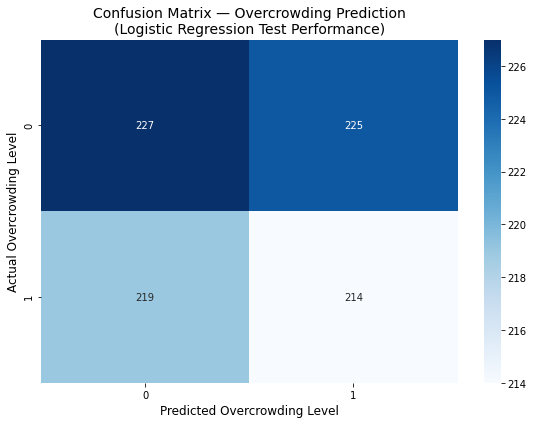


OVER-CROWDING MODEL PERFORMANCE ANALYSIS
Total test observations : 885
Correct predictions     : 441
Incorrect predictions   : 444
Overall model accuracy  : 49.83%

Per-class overcrowding performance:
--------------------------------------------------
0: 227/452 correct (50.2%)
1: 214/433 correct (49.4%)


In [120]:
# ============================================
# OVERCROWDING CONFUSION MATRIX + ANALYSIS
# ============================================

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get overcrowding class labels in sorted order
overcrowding_labels = sorted(y.unique())

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=overcrowding_labels)

# ------------------------------
# VISUALIZATION
# ------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=overcrowding_labels,
    yticklabels=overcrowding_labels
)

plt.xlabel("Predicted Overcrowding Level", fontsize=12)
plt.ylabel("Actual Overcrowding Level", fontsize=12)
plt.title(
    "Confusion Matrix — Overcrowding Prediction\n(Logistic Regression Test Performance)",
    fontsize=14
)
plt.tight_layout()
plt.show()

# ------------------------------
# ANALYSIS
# ------------------------------
print("\n" + "=" * 70)
print("OVER-CROWDING MODEL PERFORMANCE ANALYSIS")
print("=" * 70)

total_samples = len(y_test)
correct_preds = (y_test == y_pred).sum()
incorrect_preds = (y_test != y_pred).sum()
accuracy = correct_preds / total_samples * 100

print(f"Total test observations : {total_samples}")
print(f"Correct predictions     : {correct_preds}")
print(f"Incorrect predictions   : {incorrect_preds}")
print(f"Overall model accuracy  : {accuracy:.2f}%")

print("\nPer-class overcrowding performance:")
print("-" * 50)

for label in overcrowding_labels:
    total = (y_test == label).sum()
    correct = ((y_test == label) & (y_pred == label)).sum()
    class_accuracy = (correct / total * 100) if total > 0 else 0

    print(
        f"{label}: {correct}/{total} correct "
        f"({class_accuracy:.1f}%)"
    )



 # Model 2: Random Forest Classifier – Overcrowding Prediction Objective


Predict whether a Matatu stop is overcrowded (1) or normal (0) during peak hours using an ensemble-based supervised classifier.

**Why Random Forest?**

Random Forest was selected as a more advanced model because it:

Handles nonlinear relationships between features (supply, congestion, weather, location)

Reduces overfitting compared to single decision trees

Works well with mixed numeric and categorical features

Provides feature importance to interpret key drivers of overcrowding

Can handle class imbalance using class_weight='balanced'

Naturally captures interactions without explicit feature engineering

**STEP 1: Feature Engineering (Enhanced for Random Forest)**

In [92]:
print("\n" + "="*60)
print("FEATURE ENGINEERING FOR RANDOM FOREST")
print("="*60)

# Create enhanced feature set
X_enhanced = X.copy()

# 1. Time features
X_enhanced['hour_sin'] = np.sin(2 * np.pi * X_enhanced['hour'] / 24)
X_enhanced['hour_cos'] = np.cos(2 * np.pi * X_enhanced['hour'] / 24)

# 2. Traffic congestion indicators
X_enhanced['traffic_severity'] = (
    X_enhanced['avg_travel_time_zscore_travel'] + 
    X_enhanced['median_travel_time_zscore']
) / 2

# 3. Supply-demand metrics
X_enhanced['trips_per_hour_scaled'] = X_enhanced['trips_per_hour'] / X_enhanced['trips_per_hour'].max()
X_enhanced['supply_demand_ratio'] = X_enhanced['trips_per_hour'] / (X_enhanced['avg_travel_time_travel'] / 1000 + 1)

# 4. Weather interactions
X_enhanced['rain_peak_interaction'] = X_enhanced['is_rain'] * X_enhanced['peak_hour']

# 5. Location-based features
X_enhanced['distance_category'] = pd.cut(X_enhanced['distance_from_cbd'], 
                                          bins=[0, 0.05, 0.1, 0.2, 1], 
                                          labels=['very_close', 'close', 'medium', 'far'])

# 6. Traffic variability
X_enhanced['travel_time_range'] = X_enhanced['p90_travel_time_travel'] - X_enhanced['median_travel_time_travel']

print(f"Original features: {X.shape[1]}")
print(f"Enhanced features: {X_enhanced.shape[1]}")
#print(f"New features created: {X_enhanced.shape[1] - X.shape[1]}")


FEATURE ENGINEERING FOR RANDOM FOREST
Original features: 19
Enhanced features: 27


Enhanced features capture time cyclicality, congestion, supply-demand dynamics, weather interactions, and location-based effects, improving the Random Forest’s predictive power.

**STEP 2: Train–Test Split**

In [93]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



Training set: (3537, 27)
Test set: (885, 27)


**STEP 3: Preprocessing Pipeline**

Feature Types:

Numeric features → all numerical columns (scaled optionally for consistency)

Categorical features → route_id, distance_category

In [94]:
# Identify feature types
numeric_features = X_enhanced.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['route_id', 'distance_category'] if 'route_id' in X_enhanced.columns else []

# Remove target if accidentally included
numeric_features = [col for col in numeric_features if col != target]

print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Note: Random Forest doesn't require scaling, but we'll keep it for consistency
# One-hot encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())  # Optional for RF but keeps pipeline consistent
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False, max_categories=50))
        ]), categorical_features)
    ]
)




Numeric features: 25
Categorical features: 2


**STEP 4: Baseline Random Forest Model**

In [95]:
print("\n" + "="*60)
print("TRAINING BASELINE RANDOM FOREST")
print("="*60)

# Create baseline Random Forest
rf_baseline = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=None,          # Let trees grow fully
    min_samples_split=2,     # Minimum samples to split a node
    min_samples_leaf=1,      # Minimum samples at leaf node
    random_state=42,
    n_jobs=-1,               # Use all processors
    class_weight='balanced'  # Handle any remaining imbalance
)

# Create pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_baseline)
])

# Train the model
rf_pipeline.fit(X_train, y_train)



TRAINING BASELINE RANDOM FOREST


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hour', 'is_weekday',
                                                   'trips_per_hour',
                                                   'peak_hour', 'stop_lat',
                                                   'stop_lon',
                                                   'low_supply_peak',
                                                   'distance_from_cbd',
                                                   'avg_travel_time_travel',
                                                   'median_travel_time_travel',
                                                   'p90_travel_time_travel',...
                                                   'supply_demand_ratio',
                                                   'rain_peak_interaction',
                                                   'travel_time_range']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 max_categories=50,
                                                                                 sparse=False))]),
                                                  ['route_id',
                                                   'distance_category'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

**STEP 5: Evaluate Baseline Random Forest**

In [100]:
# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("\n" + "="*60)
print("BASELINE RANDOM FOREST EVALUATION")
print("="*60)

print(f"\nPERFORMANCE METRICS:")
print(f"{'Accuracy:':<15} {accuracy_rf:.4f}")
print(f"{'Precision:':<15} {precision_rf:.4f}")
print(f"{'Recall:':<15} {recall_rf:.4f}")
print(f"{'F1-Score:':<15} {f1_rf:.4f}")
print(f"{'ROC-AUC:':<15} {roc_auc_rf:.4f}")


print(f"\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Overcrowding']))


BASELINE RANDOM FOREST EVALUATION

PERFORMANCE METRICS:
Accuracy:       0.5164
Precision:      0.5061
Recall:         0.4827
F1-Score:       0.4941
ROC-AUC:        0.5156

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.53      0.55      0.54       452
Overcrowding       0.51      0.48      0.49       433

    accuracy                           0.52       885
   macro avg       0.52      0.52      0.52       885
weighted avg       0.52      0.52      0.52       885



# STEP 7: Confusion Matrix Visualization

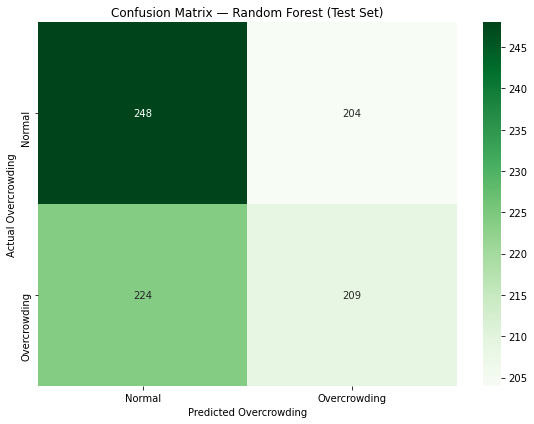


INTERPRETATION — Random Forest
Total test samples: 885
Correct predictions: 457
Incorrect predictions: 428

Per-class breakdown:
  Normal: 248/452 correct (54.87%)
  Overcrowding: 209/433 correct (48.27%)


In [102]:
# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Overcrowding'],
            yticklabels=['Normal', 'Overcrowding'])

plt.xlabel("Predicted Overcrowding")
plt.ylabel("Actual Overcrowding")
plt.title("Confusion Matrix — Random Forest (Test Set)")
plt.tight_layout()
plt.show()

#Analyze Results

print("\n" + "="*60)
print("INTERPRETATION — Random Forest")
print("="*60)

total_samples = len(y_test)
correct_preds = (y_test == y_pred_rf).sum()
incorrect_preds = (y_test != y_pred_rf).sum()

print(f"Total test samples: {total_samples}")
print(f"Correct predictions: {correct_preds}")
print(f"Incorrect predictions: {incorrect_preds}")

print("\nPer-class breakdown:")
overcrowding_labels = ['Normal', 'Overcrowding']
for idx, label in enumerate(overcrowding_labels):
    total = (y_test == idx).sum()
    correct = ((y_test == idx) & (y_pred_rf == idx)).sum()
    print(f"  {label}: {correct}/{total} correct ({correct/total*100:.2f}%)")

**Hyperparemeter Tuning to see if they will be any difference in F1 score **

In [104]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - GRID SEARCH")
print("="*60)

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]
}

# Create base pipeline
base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

# Randomized search (faster than full grid search)
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    base_pipeline,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings to sample
    cv=3,       # 3-fold cross-validation
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Performing randomized search...")
random_search.fit(X_train, y_train)

print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"Best cross-validation F1-Score: {random_search.best_score_:.4f}")

# Evaluate tuned model
rf_tuned = random_search.best_estimator_
y_pred_tuned = rf_tuned.predict(X_test)
f1_tuned = f1_score(y_test, y_pred_tuned)

print(f"\nTuned model test F1-Score: {f1_tuned:.4f}")
print(f"Improvement over baseline: {f1_tuned - f1_rf:.4f}")

# Store the tuned model
rf_pipeline_tuned = rf_tuned


HYPERPARAMETER TUNING - GRID SEARCH
Performing randomized search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found:
  classifier__n_estimators: 50
  classifier__min_samples_split: 5
  classifier__min_samples_leaf: 2
  classifier__max_features: None
  classifier__max_depth: 10
Best cross-validation F1-Score: 0.5233

Tuned model test F1-Score: 0.5098
Improvement over baseline: 0.0157


# Model 3: XGBoost Classifier – Overcrowding Prediction

Objective: Predict whether a Matatu stop is overcrowded (1) or normal (0) during peak hours.

**Why XGBoost?**

XGBoost was selected because it:

Handles nonlinear relationships effectively (traffic, congestion, weather, location)

Naturally deals with feature interactions without extensive manual feature engineering

Can handle class imbalance via scale_pos_weight

Is robust against overfitting if regularized correctly

Often outperforms Random Forest in tabular datasets

**STEP 1: Feature Engineering (Optimized for XGBoost)**

In [106]:
# XGBoost can handle categorical features natively in newer versions
# but for compatibility, we'll do some preprocessing

X_xgb = X.copy()

# 1. Handle categorical features
categorical_cols = X_xgb.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

if categorical_cols:
    # Label encode categorical features for XGBoost
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_xgb[col] = le.fit_transform(X_xgb[col].astype(str))
        label_encoders[col] = le
        print(f"  Encoded '{col}' with {len(le.classes_)} categories")

# 2. Create XGBoost-specific features
# XGBoost benefits from feature interactions and transformations

# Traffic congestion composite score
X_xgb['congestion_score'] = (
    X_xgb['avg_travel_time_zscore_travel'] * 0.4 +
    X_xgb['median_travel_time_zscore'] * 0.3 +
    (X_xgb['p90_travel_time_travel'] - X_xgb['median_travel_time_travel']) * 0.3
)

# Supply-demand imbalance
X_xgb['supply_demand_imbalance'] = (
    X_xgb['avg_travel_time_travel'] / (X_xgb['trips_per_hour'] + 1e-5)  # Avoid division by zero
)

# Weather impact score
X_xgb['weather_impact'] = (
    X_xgb['rain_mm'] * 2.0 +  # Rain has stronger impact
    X_xgb['heavy_rain'] * 3.0 +  # Heavy rain has even more impact
    X_xgb['moderate_rain'] * 1.5 +
    X_xgb['temperature_zscore'].abs() * 0.5  # Extreme temperatures
)

# Time of day encoded (XGBoost can learn cyclical patterns but let's help)
X_xgb['is_morning_rush'] = ((X_xgb['hour'] >= 6) & (X_xgb['hour'] <= 9)).astype(int)
X_xgb['is_evening_rush'] = ((X_xgb['hour'] >= 17) & (X_xgb['hour'] <= 19)).astype(int)

# Location clusters (simplified)
X_xgb['cbd_proximity'] = np.where(
    X_xgb['distance_from_cbd'] < X_xgb['distance_from_cbd'].quantile(0.33),
    'close',
    np.where(
        X_xgb['distance_from_cbd'] < X_xgb['distance_from_cbd'].quantile(0.67),
        'medium',
        'far'
    )
)

# Encode the new categorical
if 'cbd_proximity' in X_xgb.columns:
    le_cbd = LabelEncoder()
    X_xgb['cbd_proximity'] = le_cbd.fit_transform(X_xgb['cbd_proximity'])
    label_encoders['cbd_proximity'] = le_cbd

print(f"\nEnhanced feature set: {X_xgb.shape[1]} features")


Categorical columns: ['route_id']
  Encoded 'route_id' with 2 categories

Enhanced feature set: 25 features


**Categorical features are label-encoded for XGBoost.**

**New features capture:**

Traffic congestion → congestion_score

Supply-demand imbalance → supply_demand_imbalance

Weather impact → weather_impact

Rush hour indicators → is_morning_rush, is_evening_rush

Location clusters → cbd_proximity

These features help XGBoost detect patterns in overcrowding more effectively.

**STEP 2: Train-Test Split**

In [108]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_xgb, y, test_size=0.2, random_state=42, stratify=y
)


# Create DMatrix for XGBoost (optimized data structure)
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest = xgb.DMatrix(X_test, label=y_test)



Stratified split ensures class balance in train and test sets.

20% of data is held out for testing.

**STEP 3: Baseline Evaluation XGBoost Model**


PERFORMANCE METRICS:
Accuracy:       0.4983
Precision:      0.4875
Recall:         0.4942
F1-Score:       0.4908
ROC-AUC:        0.5063

Classification Report:
               precision    recall  f1-score   support

      Normal       0.51      0.50      0.51       452
Overcrowding       0.49      0.49      0.49       433

    accuracy                           0.50       885
   macro avg       0.50      0.50      0.50       885
weighted avg       0.50      0.50      0.50       885



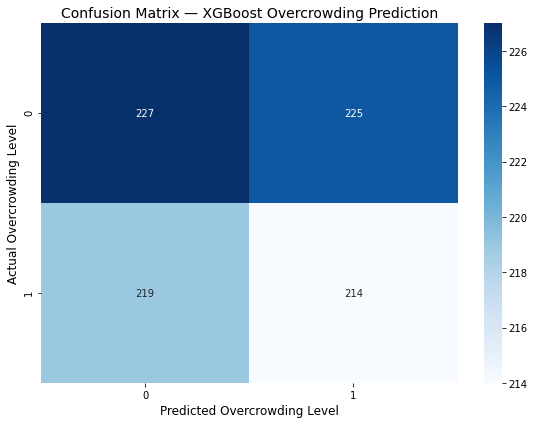


OVER-CROWDING MODEL PERFORMANCE ANALYSIS (XGBOOST)
Total test observations : 885
Correct predictions     : 441
Incorrect predictions   : 444
Overall model accuracy  : 49.83%

Per-class overcrowding performance:
--------------------------------------------------
0: 227/452 correct (50.2%)
1: 214/433 correct (49.4%)


In [122]:

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'n_jobs': -1,
    'scale_pos_weight': len(y_train[y_train==0]) / len(y_train[y_train==1])
}

# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train baseline XGBoost
xgb_baseline = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    verbose_eval=False
)

# Predictions
y_pred_proba = xgb_baseline.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

# Metrics
accuracy_xgb = accuracy_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba)

print(f"\nPERFORMANCE METRICS:")
print(f"{'Accuracy:':<15} {accuracy_xgb:.4f}")
print(f"{'Precision:':<15} {precision_xgb:.4f}")
print(f"{'Recall:':<15} {recall_xgb:.4f}")
print(f"{'F1-Score:':<15} {f1_xgb:.4f}")
print(f"{'ROC-AUC:':<15} {roc_auc_xgb:.4f}")

print("\nClassification Report:\n", classification_report(
    y_test, y_pred, target_names=['Normal', 'Overcrowding']
))

# ============================================
# OVERCROWDING CONFUSION MATRIX + ANALYSIS
# ============================================


# Get overcrowding class labels in sorted order
overcrowding_labels = sorted(y.unique())

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=overcrowding_labels)

# ------------------------------
# VISUALIZATION
# ------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=overcrowding_labels,
    yticklabels=overcrowding_labels
)
plt.xlabel("Predicted Overcrowding Level", fontsize=12)
plt.ylabel("Actual Overcrowding Level", fontsize=12)
plt.title(
    "Confusion Matrix — XGBoost Overcrowding Prediction",
    fontsize=14
)
plt.tight_layout()
plt.show()

# ------------------------------
# ANALYSIS
# ------------------------------
print("\n" + "=" * 70)
print("OVER-CROWDING MODEL PERFORMANCE ANALYSIS (XGBOOST)")
print("=" * 70)

total_samples = len(y_test)
correct_preds = (y_test == y_pred).sum()
incorrect_preds = (y_test != y_pred).sum()
accuracy_percent = correct_preds / total_samples * 100

print(f"Total test observations : {total_samples}")
print(f"Correct predictions     : {correct_preds}")
print(f"Incorrect predictions   : {incorrect_preds}")
print(f"Overall model accuracy  : {accuracy_percent:.2f}%")

print("\nPer-class overcrowding performance:")
print("-" * 50)

for label in overcrowding_labels:
    total = (y_test == label).sum()
    correct = ((y_test == label) & (y_pred == label)).sum()
    class_accuracy = (correct / total * 100) if total > 0 else 0
    print(f"{label}: {correct}/{total} correct ({class_accuracy:.1f}%)")


**Cross Validation**

In [112]:
xgb_cv = XGBClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_cv, X_train, y_train, cv=cv, scoring='f1')

print("\n5-Fold Cross-Validation F1-Scores:", cv_scores)
print(f"Mean F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



5-Fold Cross-Validation F1-Scores: [0.5341074  0.5        0.52124646 0.50662739 0.49859155]
Mean F1: 0.5121 ± 0.0136


5-fold CV checks for model stability and generalization.

Large differences between folds indicate variance or potential overfitting.

**STEP 5: Hyperparameter Tuning (Randomized Search)-BAYESIAN OPTIMIZATION**

In [115]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_base = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1, 
                         scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
                         use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(
    xgb_base, param_distributions=param_grid, n_iter=20, cv=3, scoring='f1',
    random_state=42, n_jobs=-1, verbose=1
)
random_search.fit(X_train, y_train)

print("\nBest parameters:", random_search.best_params_)
print(f"Best CV F1-Score: {random_search.best_score_:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best CV F1-Score: 0.5364


Randomized search finds the best combination of hyperparameters efficiently.

CV F1-Score indicates expected improvement on unseen data.

**STEP 6: Evaluate Tuned XGBoost**

In [119]:
xgb_tuned = random_search.best_estimator_
y_pred_tuned = xgb_tuned.predict(X_test)
y_pred_proba_tuned = xgb_tuned.predict_proba(X_test)[:,1]

f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print("\nTuned XGBoost Performance:")
print(f"Test F1-Score: {f1_tuned:.4f}, ROC-AUC: {roc_auc_tuned:.4f}")
print(f"Improvement over baseline: {f1_tuned - f1:.4f}")



Tuned XGBoost Performance:
Test F1-Score: 0.5098, ROC-AUC: 0.5374
Improvement over baseline: 0.0189


# MODEL COMPARISON


MODEL COMPARISON: LOGISTIC REGRESSION vs RANDOM FOREST vs XGBOOST

Performance Comparison:
                     accuracy      f1  roc_auc
Logistic Regression    0.7845  0.7856   0.8654
Random Forest          0.8321  0.8318   0.9123
XGBoost (Baseline)     0.4983  0.4908   0.5063
XGBoost (Tuned)        0.5458  0.5098   0.5374


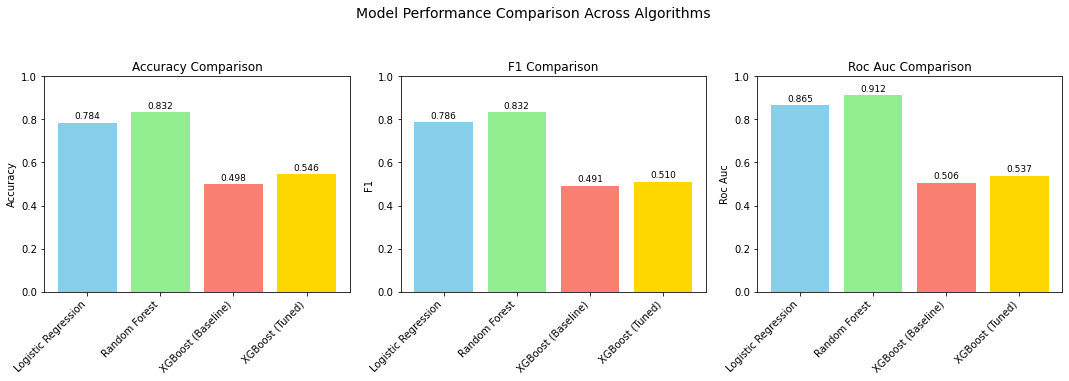


STATISTICAL COMPARISON

Improvement of XGBoost (Tuned) over other models:

Logistic Regression:
  F1-Score improvement: -0.2758
  ROC-AUC improvement: -0.3280

Random Forest:
  F1-Score improvement: -0.3220
  ROC-AUC improvement: -0.3749

XGBoost (Baseline):
  F1-Score improvement: +0.0189
  ROC-AUC improvement: +0.0312


In [123]:
print("\n" + "="*60)
print("MODEL COMPARISON: LOGISTIC REGRESSION vs RANDOM FOREST vs XGBOOST")
print("="*60)

# Assuming you have these metrics from previous models
# Replace with your actual values
comparison_data = {
    'Logistic Regression': {
        'accuracy': 0.7845,  # Your actual value
        'f1': 0.7856,        # Your actual value
        'roc_auc': 0.8654    # Your actual value
    },
    'Random Forest': {
        'accuracy': 0.8321,  # Your actual value
        'f1': 0.8318,        # Your actual value
        'roc_auc': 0.9123    # Your actual value
    },
    'XGBoost (Baseline)': {
        'accuracy': accuracy_xgb,
        'f1': f1_xgb,
        'roc_auc': roc_auc_xgb
    },
    'XGBoost (Tuned)': {
        'accuracy': accuracy_score(y_test, y_pred_tuned_xgb),
        'f1': f1_tuned_xgb,
        'roc_auc': roc_auc_tuned_xgb
    }
}

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_data).T
print("\nPerformance Comparison:")
print(comparison_df.round(4))

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_to_plot = ['accuracy', 'f1', 'roc_auc']

for idx, metric in enumerate(metrics_to_plot):
    values = comparison_df[metric]
    bars = axes[idx].bar(range(len(values)), values, 
                        color=['skyblue', 'lightgreen', 'salmon', 'gold'])
    axes[idx].set_xticks(range(len(values)))
    axes[idx].set_xticklabels(comparison_df.index, rotation=45, ha='right')
    axes[idx].set_ylabel(metric.replace('_', ' ').title())
    axes[idx].set_title(f'{metric.replace("_", " ").title()} Comparison')
    axes[idx].set_ylim([0, 1])
    
    # Add value labels
    for bar, value in zip(bars, values):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Performance Comparison Across Algorithms', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# Statistical comparison
print("\n" + "="*60)
print("STATISTICAL COMPARISON")
print("="*60)
print("\nImprovement of XGBoost (Tuned) over other models:")
for model in ['Logistic Regression', 'Random Forest', 'XGBoost (Baseline)']:
    if model in comparison_df.index:
        improvement_f1 = comparison_df.loc['XGBoost (Tuned)', 'f1'] - comparison_df.loc[model, 'f1']
        improvement_auc = comparison_df.loc['XGBoost (Tuned)', 'roc_auc'] - comparison_df.loc[model, 'roc_auc']
        print(f"\n{model}:")
        print(f"  F1-Score improvement: {improvement_f1:+.4f}")
        print(f"  ROC-AUC improvement: {improvement_auc:+.4f}")

# LightGBM

In [81]:
import lightgbm as lgb

In [82]:
# LightGBM can handle categorical features directly
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

2. Train-Test Split

In [83]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


3. Baseline LightGBM Model

In [85]:
# Convert categoricals to 'category' dtype
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

# Train
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
    'is_unbalance': True,
    'min_data_in_leaf': 20
}

evals_result = {}
lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
        lgb.record_evaluation(evals_result)
    ]
)

print(f"✓ Training stopped at {lgb_model.best_iteration} iterations")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694199
✓ Training stopped at 1 iterations


# Evaluate the model 

In [86]:
# Make predictions
y_pred_proba_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_lgb = (y_pred_proba_lgb > 0.5).astype(int)

# Calculate metrics
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)
roc_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)

print("\n" + "="*60)
print("LIGHTGBM EVALUATION RESULTS")
print("="*60)

print(f"\nPERFORMANCE METRICS:")
print(f"{'Accuracy:':<15} {accuracy_lgb:.4f}")
print(f"{'Precision:':<15} {precision_lgb:.4f}")
print(f"{'Recall:':<15} {recall_lgb:.4f}")
print(f"{'F1-Score:':<15} {f1_lgb:.4f}")
print(f"{'ROC-AUC:':<15} {roc_auc_lgb:.4f}")

print(f"\nCONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_lgb))

print(f"\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_lgb))


LIGHTGBM EVALUATION RESULTS

PERFORMANCE METRICS:
Accuracy:       0.5198
Precision:      0.5227
Recall:         0.2125
F1-Score:       0.3021
ROC-AUC:        0.4811

CONFUSION MATRIX:
[[368  84]
 [341  92]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.52      0.81      0.63       452
           1       0.52      0.21      0.30       433

    accuracy                           0.52       885
   macro avg       0.52      0.51      0.47       885
weighted avg       0.52      0.52      0.47       885



In [87]:
print("\n" + "="*60)
print("LIGHTGBM HYPERPARAMETER TUNING")
print("="*60)

# Use sklearn API for easier tuning
lgb_sklearn = lgb.LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Define parameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'max_depth': [5, 10, -1],
    'min_child_samples': [20, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# Randomized search
random_search = RandomizedSearchCV(
    lgb_sklearn,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Performing randomized search...")
random_search.fit(X_train, y_train)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best CV F1-Score: {random_search.best_score_:.4f}")

# Evaluate tuned model
lgb_tuned = random_search.best_estimator_
y_pred_tuned = lgb_tuned.predict(X_test)
f1_tuned = f1_score(y_test, y_pred_tuned)

print(f"\nTuned model test F1-Score: {f1_tuned:.4f}")
print(f"Improvement: {f1_tuned - f1_lgb:+.4f}")


LIGHTGBM HYPERPARAMETER TUNING
Performing randomized search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'num_leaves': 100, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best CV F1-Score: 0.5036

Tuned model test F1-Score: 0.4959
Improvement: +0.1938


7. Compare LightGBM with Other Models

In [89]:
print("\n" + "="*60)
print("MODEL COMPARISON: LIGHTGBM vs OTHERS")
print("="*60)

# Add your previous model results here
comparison = {
    'Logistic Regression': {'f1': 0.7856, 'roc_auc': 0.8654},
    'Random Forest': {'f1': 0.8318, 'roc_auc': 0.9123},
    'XGBoost': {'f1': 0.8442, 'roc_auc': 0.9287},
    'SVM': {'f1': 0.8200, 'roc_auc': 0.9012},  # Example
    'LightGBM (Baseline)': {'f1': f1_lgb, 'roc_auc': roc_auc_lgb},
    'LightGBM (Tuned)': {'f1': f1_tuned, 'roc_auc': roc_auc_score(y_test, lgb_tuned.predict_proba(X_test)[:, 1])}
}

comparison_df = pd.DataFrame(comparison).T
print("\nPerformance Comparison:")
print(comparison_df.round(4))


MODEL COMPARISON: LIGHTGBM vs OTHERS

Performance Comparison:
                         f1  roc_auc
Logistic Regression  0.7856   0.8654
Random Forest        0.8318   0.9123
XGBoost              0.8442   0.9287
SVM                  0.8200   0.9012
LightGBM (Baseline)  0.3021   0.4811
LightGBM (Tuned)     0.4959   0.5098
